In [1]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
import torch.nn.functional as F


In [2]:
network_config = {}
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# implement a basic tokenizer from scratch (Anderj Karpathy's tutorial)
class BasicTokenizer:
    def __init__(self, vocab_size=300):
        self.vocab = {}
        self.merges = {}
        self.vocab_size = vocab_size
        # self.ids = []
    def train(self, text, verbose=False):
        tokens = self.read_file(text)
        num_merge = self.vocab_size - 256
        ids = tokens.copy()
        for i in range(num_merge):
            num_merge = 256 + i
            stats = self.get_stats(ids)
            top_pair = self.get_top_pair(stats)
            if verbose:
                print(f"merging {top_pair} into {num_merge}")
            ids = self.merge(ids, top_pair, num_merge)
            self.merges[top_pair] = num_merge
        self.vocab = {idx: bytes([idx]) for idx in range(256)}
        for (p1, p2), idx in self.merges.items():
            self.vocab[idx] = self.vocab[p1] + self.vocab[p2]
        # self.ids = ids
        return ids
    
    def read_file(self, text):
        tokens = text.encode("utf-8")
        tokens = list(map(int, tokens))
        return tokens
    def get_stats(self, tokens):
        maps = {}
        for p1, p2 in zip(tokens, tokens[1:]):
            maps[(p1, p2)] = maps.get((p1, p2), 0) + 1
        return maps
    def get_top_pair(self, maps):
        top_pair = max(maps, key=maps.get)
        # self.merges.append(top_pair)
        return top_pair
    def merge(self, ids, top_pair, idx):
        res = []
        i = 0
        p1, p2 = top_pair
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == p1 and ids[i+1] == p2:
                self.merges[top_pair] = idx
                res.append(idx)
                i += 2
            else:
                res.append(ids[i])
                i += 1
        return res
    def encode(self, text):
        tokens = self.read_file(text)
        ids = tokens.copy()
        i = 0
        res = []
        while i < len(ids):
            if i < len(ids) - 1 and (ids[i], ids[i+1]) in self.merges:
                res.append(self.merges[(ids[i], ids[i+1])])
                i+=2
            else:
                res.append(ids[i])
                i+=1
        return res
    def decode(self, ids):
        bytes_string = b"".join(self.vocab[idx] for idx in ids)
        return bytes_string.decode("utf-8", errors="replace")
    

In [4]:
tokenizer = BasicTokenizer()
text = open("./data/books.txt", "r", encoding="utf-8").read()
tokenizer.train(text)
tokens = tokenizer.encode(text)
# print(tokens)
print(tokenizer.decode(tokens) == text)

True


In [5]:
print(tokenizer.encode("I lvoe you"))

[73, 32, 108, 118, 111, 256, 121, 264]


In [6]:
dataset = torch.tensor(tokens, dtype=torch.long).to(device)
print(dataset.shape, dataset.dtype)

print(dataset)

torch.Size([486001]) torch.int64
tensor([ 73, 288,  97,  ..., 115,  10,  46], device='cuda:0')


In [7]:
def get_batch(dataset, batch_size, context_window, split="train"):
    # 1. 获取数据集长度并划分数据集
    data_length = len(dataset)
    train_size = int(data_length * 0.8)
    val_size = int(data_length * 0.1)
    
    # 2. 根据split参数选择数据范围
    if split == "train":
        data = dataset[:train_size]
        valid_range = train_size - context_window
    elif split == "val":
        data = dataset[train_size:train_size + val_size]
        valid_range = val_size - context_window
    elif split == "test":
        data = dataset[train_size + val_size:]
        valid_range = len(data) - context_window
    else:
        raise ValueError("Invalid split: choose 'train', 'val', or 'test'")
    
    # 3. 随机生成起始索引
    if valid_range <= 0:
        raise ValueError(f"Context window {context_window} too large for split {split}")
    
    start_indices = torch.randint(0, valid_range, (batch_size,))
    
    # 4. 构建输入输出对
    x = torch.stack([data[i:i+context_window] for i in start_indices])
    y = torch.stack([data[i+1:i+context_window+1] for i in start_indices])
    
    return x.to(device), y.to(device)

In [8]:
network_config.update({
    'batch_size': 16,
    'context_window': 16,
})


In [9]:
xs, ys = get_batch(dataset, **network_config)
print([tokenizer.decode(ids) for ids in xs.tolist()])
print([tokenizer.decode(ids) for ids in ys.tolist()])

['arted in the second year', 'o reasons: (1) we try ', 'se goals without consid', 'ope, Asia, and the Mid', 'of energy took over m', 'experiences after lea', 'ake advantage of the f', 'who give us inspirati', 'd white birds often se', 'al emotions on our habit', 'gular practice or rou', 'y smaller trips to dec', 'own. You can just as e', 'since you’ve been si', 'cause they were obviou', 'willing to do things I ']
['ted in the second year, ', 'reasons: (1) we try t', 'e goals without consider', 'pe, Asia, and the Midd', ' energy took over my ', 'xperiences after leav', 'ke advantage of the fre', 'ho give us inspiration', 'white birds often seen', ' emotions on our habits', 'ular practice or routi', 'smaller trips to deci', 'wn. You can just as ea', 'ince you’ve been sic', 'ause they were obvious ', 'illing to do things I d']


In [10]:
def get_loss(model, network_config):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            x, y = get_batch(dataset, **network_config, split=split)
            _, loss = model(x, y)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [11]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
        self.linear1 = nn.Linear(self.embed_dim, self.embed_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(self.embed_dim, self.vocab_size)
        print(f"#params: {sum(p.numel() for p in self.parameters())}")

    def forward(self, x, target=None):
        B, T = x.shape
        x = self.embedding(x)
        x = self.linear1(x)
        x = self.relu(x)
        logits = self.linear2(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), target.view(-1))
            return logits, loss
        return logits


In [12]:
model = MLP(tokenizer.vocab_size, 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#params: 93612


In [13]:
def train(model, optimizer, network_config, epoch=100, verbose=False):
    losses = []
    val_losses = []
    start = time.time()
    for i in range(epoch):
        x, y = get_batch(dataset, **network_config)
        out, loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # losses.append(loss.item())
        # if verbose:
        if i % 100 == 0:
            losses.append(loss.item())
            with torch.no_grad():
                x_val, y_val = get_batch(dataset, **network_config, split="val")
                out_val, loss_val = model(x_val, y_val)
                val_losses.append(loss_val.item())
                if verbose:
                    print(f"epoch {i} loss: {loss.item()}, val loss: {loss_val.item()}")

    print(f"train time: {time.time() - start}")
    print(f"train loss: {np.mean(loss.item())}")
    print(f"val loss: {np.mean(loss_val.item())}")
    return losses, val_losses




In [14]:
train_loss, val_losses = train(model, optimizer, network_config, epoch=10000, verbose=False)


train time: 13.30544137954712
train loss: 3.0695602893829346
val loss: 3.085247278213501


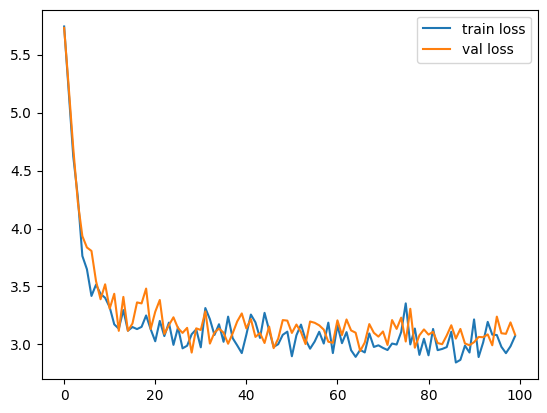

In [15]:
plt.plot(train_loss, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

In [16]:
def generate(model, network_config, tokenizer, context_window=16, max_tokens=100):
    model.eval()
    idx = torch.zeros((1, context_window), dtype=torch.long).to(device)
    for _ in range(max_tokens):
        out = model(idx)
        # 只保留最后一个时间步的输出，因为我们只需要预测下一个token
        # shape: (batch_size, seq_len, vocab_size) -> (batch_size, vocab_size)
        # 取输出的最后一个时间步的预测结果
        # 输入形状: (batch_size, sequence_len, vocab_size)
        # 输出形状: (batch_size, vocab_size)
        # 例如输入是[0,0,0,...,0], 输出预测下一个token [0,0,0,...,1]
        # 我们只需要最后一个时间步的预测,即最后预测出的token
        out = out[:, -1, :]
        # 将输出转换为概率分布，使用softmax将logits转换为概率值
        probs = torch.softmax(out, dim=-1)
        # 根据概率分布随机采样下一个token的索引，num_samples=1表示只采样一个token
        idx_next = torch.multinomial(probs, num_samples=1)
        # 将新预测的token添加到idx中，用于下一次预测
        idx = torch.cat((idx, idx_next), dim=-1)
    return tokenizer.decode(idx.squeeze().tolist())

print(generate(model, network_config, tokenizer))

                ulw gug Yournd yek pe to bithelfiodveamore be d. It ainghe mocizing mbey k and itt berings worm tht h, th, th onessyou Woriapemese warnor


RMSNorm part

In [17]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps, partial=-1):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(dim))
        self.eps = eps
        self.partial = partial

    def forward(self, x):
        origin_shape = x.shape
        x = x.view(-1, x.shape[-1])
        if 1 >= self.partial > 0:
            partial_size = int(self.partial * x.shape[-1])
            mask = torch.rand(x.shape[-1]) < self.partial # random select index
            x_partial = x[:, mask] # select partial index
            rms = torch.sqrt(x_partial.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        else:
            rms = torch.sqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        
        x_normalized = x / rms
        x_scaled = x_normalized * self.scale
        return x_scaled.view(origin_shape)


In [18]:
class MLP_rms(nn.Module):
    def __init__(self, network_config, vocab_size, embed_dim):
        super().__init__()
        self.network_config = network_config
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
        self.rms = RMSNorm(self.embed_dim, eps=1e-5)
        self.linear = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_dim),
            nn.ReLU(),
            nn.Linear(self.embed_dim, self.vocab_size)
        )
        print(f"#params: {sum(p.numel() for p in self.parameters())}")

    def forward(self, x, target=None):
        x = self.embedding(x)
        x = self.rms(x)
        logits = self.linear(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.shape[-1]), target.view(-1))
            return logits, loss
        return logits


In [19]:
model = MLP_rms(network_config, tokenizer.vocab_size, 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loss, val_loss = train(model, optimizer, network_config, epoch=10000, verbose=False)

#params: 93740


train time: 16.233333826065063
train loss: 3.0605309009552
val loss: 3.1518170833587646


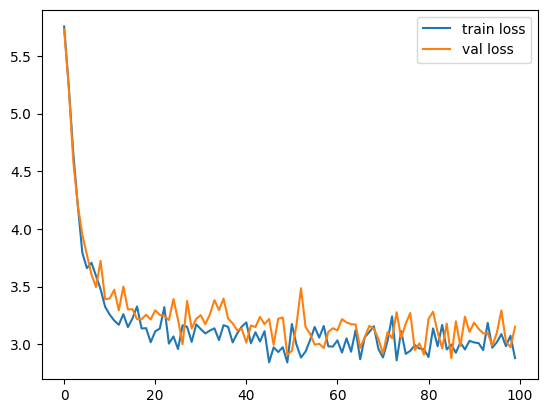

In [20]:
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()


RoPE part

In [21]:
class RoPE(nn.Module):
    def __init__(self, dim, base=10000):
        super().__init__()
        self.dim = dim
        self.base = base
        inv_freq = 1.0 / (base**(torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)

    def forward(self, x):
    # x: [batch_size, num_heads, seq_len, head_dim]
    # head_dim 必须是偶数
    # 1. 计算旋转所需的角度（只算一半的维度）
    #    假设 inv_freq 的形状是 [head_dim/2]
        seq_len = x.shape[2]
        pos = torch.arange(seq_len, device=x.device)                 # [seq_len]
        angles = pos[:, None] * self.inv_freq[None, :]               # [seq_len, head_dim/2]

        # 2. 得到对应的 sin, cos，并加上 batch/head 维做广播
        sin = angles.sin()[None, None, :, :]  # [1,1,seq_len,head_dim/2]
        cos = angles.cos()[None, None, :, :]

        # 3. 将输入拆成两部分，分别乘以 cos 和 sin 来做旋转
        x1, x2 = x.chunk(2, dim=-1)  # x1,x2: [batch_size, num_heads, seq_len, head_dim/2]
        out = torch.cat([x1*cos - x2*sin, x2*cos + x1*sin], dim=-1)  # [batch_size, num_heads, seq_len, head_dim]

        return out


In [22]:
rope = RoPE(128, base=1000).to(device)
x = torch.randn(1, 8, 16, 128).to(device)
x_rot = rope(x)
print(x_rot.shape)

torch.Size([1, 8, 16, 128])


In [23]:
import math
class RoPeMultiHeadAttention(nn.Module):
    def __init__(self, network_config, embed_dim, num_heads):
        super().__init__()
        self.network_config = network_config
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim
        self.wq = nn.Linear(embed_dim, embed_dim)
        self.wk = nn.Linear(embed_dim, embed_dim)
        self.wv = nn.Linear(embed_dim, embed_dim)
        self.wo = nn.Linear(embed_dim, embed_dim)
        self.rope = RoPE(self.head_dim, base=10000)

    def get_causal_mask(self, seq_len, device):
        mask = torch.ones((seq_len, seq_len), device=device).tril()
        mask = mask.log()
        return mask
        
    def forward(self, x):
        B, T, C = x.shape
        
        # 线性变换并分头
        q = self.wq(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.wk(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.wv(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        
        # 应用RoPE编码
        q = self.rope(q)
        k = self.rope(k)
        
        # 计算注意力分数
        scale = 1.0 / math.sqrt(self.head_dim)
        attn = torch.matmul(q, k.transpose(-2, -1)) * scale  # [B, nh, T, T]
        
        # 应用因果掩码
        causal_mask = self.get_causal_mask(T, x.device)
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, T, T]
        
        # 将掩码加到注意力分数上（不使用masked_fill）
        attn = attn + causal_mask
        
        # 应用softmax
        attn = F.softmax(attn, dim=-1)
        
        # 计算输出
        out = torch.matmul(attn, v)  # [B, nh, T, T] x [B, nh, T, hd] -> [B, nh, T, hd]
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.wo(out)
        
        return out


In [24]:
class RopeModel(nn.Module):
    def __init__(self, network_config, vocab_size, embed_dim, num_heads):
        super().__init__()
        self.network_config = network_config
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.mha = RoPeMultiHeadAttention(network_config, embed_dim, num_heads)
        self.rms1 = RMSNorm(embed_dim, eps=1e-5)
        self.rms2 = RMSNorm(embed_dim, eps=1e-5)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU()
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size)
        print(f"#params: {sum(p.numel() for p in self.parameters())}")
    def forward(self, x, target=None):
        x = self.embedding(x)
        x = self.rms1(x)
        x = x + self.mha(x)
        x = self.rms2(x)
        x = x + self.linear(x)
        logits = self.lm_head(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), target.view(-1))
            return logits, loss
        return logits


#params: 159916


train time: 35.25424885749817
train loss: 2.4258930683135986
val loss: 2.7325639724731445


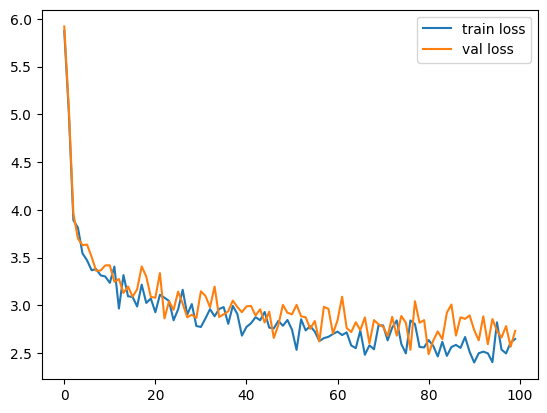

In [26]:
model = RopeModel(network_config, tokenizer.vocab_size, 128, 8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loss, val_loss = train(model, optimizer, network_config, epoch=10000, verbose=False)
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()


SwiGLU Part

In [27]:
class SwiGLU(nn.Module):
    def __init__(self, in_features, hidden_features):
        super().__init__()
        hidden_features = hidden_features or in_features * 2
        self.w1 = nn.Linear(in_features, hidden_features)
        self.w2 = nn.Linear(in_features, hidden_features)
        self.proj = nn.Linear(hidden_features, in_features)

    def forward(self, x):
        gate = self.w1(x)
        value = self.w2(x)
        gate_activated = F.silu(gate)
        gate_value = gate_activated * value
        return self.proj(gate_value)


In [28]:
class RopeModel(nn.Module):
    def __init__(self, network_config, vocab_size, embed_dim, num_heads):
        super().__init__()
        self.network_config = network_config
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.mha = RoPeMultiHeadAttention(network_config, embed_dim, num_heads)
        self.rms1 = RMSNorm(embed_dim, eps=1e-5)
        self.rms2 = RMSNorm(embed_dim, eps=1e-5)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            SwiGLU(embed_dim, embed_dim * 4) # change relu to swiglu
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size)
        print(f"#params: {sum(p.numel() for p in self.parameters())}")
    def forward(self, x, target=None):
        x = self.embedding(x)
        x = self.rms1(x)
        x = x + self.mha(x)
        x = self.rms2(x)
        x = x + self.linear(x)
        logits = self.lm_head(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), target.view(-1))
            return logits, loss
        return logits


#params: 357676


train time: 38.19033074378967
train loss: 2.364229679107666
val loss: 2.6831443309783936


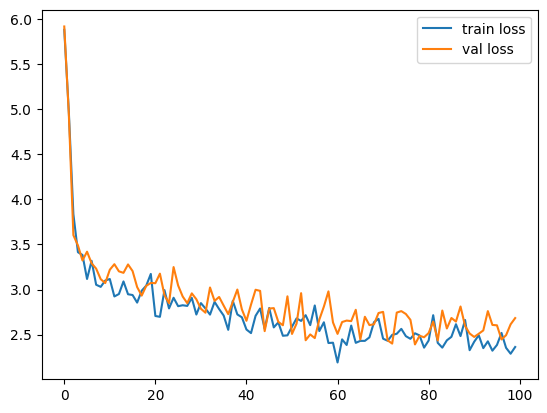

In [30]:
model = RopeModel(network_config, tokenizer.vocab_size, 128, 8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loss, val_loss = train(model, optimizer, network_config, epoch=10000, verbose=False)
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()


In [31]:
class LlamaBlock(nn.Module):
    def __init__(self, network_config, embed_dim, num_heads):
        super().__init__()
        self.network_config = network_config
        self.rms1 = RMSNorm(embed_dim, eps=1e-5)
        self.mha = RoPeMultiHeadAttention(network_config, embed_dim, num_heads)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            SwiGLU(embed_dim*2, embed_dim * 4),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        self.rms2 = RMSNorm(embed_dim, eps=1e-5)
        print(f"#params: {sum(p.numel() for p in self.parameters())}")
    def forward(self, x):
        x = self.rms1(x)
        x = x + self.mha(x)
        x = self.rms2(x)
        x = x + self.feedforward(x)
        return x


In [32]:
# test model
block = LlamaBlock(network_config, 128, 8).to(device)
x = torch.randn(1, 16, 128).to(device)
out = block(x)
print(out.shape)


#params: 526720
torch.Size([1, 16, 128])


In [35]:
from collections import OrderedDict
class Llama(nn.Module):
    def __init__(self, network_config, vocab_size, embed_dim, num_heads, num_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.llama_blocks = nn.Sequential(
            OrderedDict([
                (f"llama_{i}", LlamaBlock(network_config, embed_dim, num_heads)) for i in range(num_layers)])
        )
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            SwiGLU(embed_dim, embed_dim * 4),
            nn.Linear(embed_dim, embed_dim)
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size)
        print(f"total #params: {sum(p.numel() for p in self.parameters())}")
    def forward(self, x, target=None):
        x = self.embeddings(x)
        x = self.llama_blocks(x)
        x = self.ffn(x)
        logits = self.lm_head(x)
        if target is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), target.view(-1))
            return logits, loss
        return logits


In [36]:
llama = Llama(network_config, tokenizer.vocab_size, 128, 8, 8).to(device)

#params: 526720
#params: 526720
#params: 526720
#params: 526720
#params: 526720
#params: 526720
#params: 526720
#params: 526720
total #params: 4521644


train time: 273.59917998313904
train loss: 1.8617359399795532
val loss: 1.9922596216201782


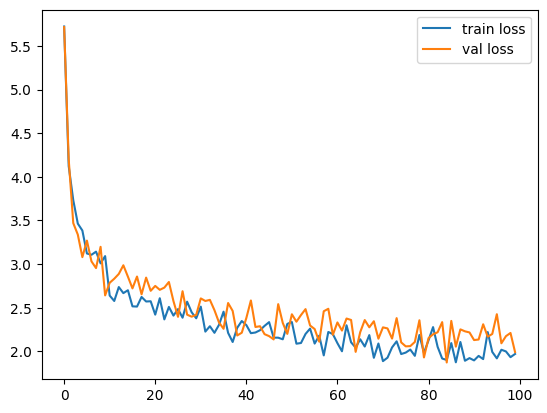

In [37]:
optimizer = torch.optim.Adam(llama.parameters(), lr=1e-4)
train_loss, val_loss = train(llama, optimizer, network_config, epoch=10000, verbose=False)
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()

In [38]:
print(generate(llama, network_config, tokenizer))

                ou live perspected by the complea bligive on the runinters thopects of the sopopendevopectinyourowableacticusectivishe becccut 


#params: 2102016
#params: 2102016
#params: 2102016


#params: 2102016
#params: 2102016
#params: 2102016
#params: 2102016
#params: 2102016
total #params: 17890348
epoch 0 loss: 5.698664665222168, val loss: 5.700592041015625
epoch 100 loss: 3.77457594871521, val loss: 3.8389532566070557
epoch 200 loss: 3.2714850902557373, val loss: 3.342360258102417
epoch 300 loss: 2.998931407928467, val loss: 3.130413770675659
epoch 400 loss: 3.045306444168091, val loss: 3.0127129554748535
epoch 500 loss: 2.733171224594116, val loss: 2.8973910808563232
epoch 600 loss: 2.6829373836517334, val loss: 2.7952215671539307
epoch 700 loss: 2.4734201431274414, val loss: 2.723071813583374
epoch 800 loss: 2.554272174835205, val loss: 2.603431224822998
epoch 900 loss: 2.414365768432617, val loss: 2.5831475257873535
epoch 1000 loss: 2.386390447616577, val loss: 2.508836030960083
epoch 1100 loss: 2.331998586654663, val loss: 2.507416009902954
epoch 1200 loss: 2.243602991104126, val loss: 2.4888081550598145
epoch 1300 loss: 2.285554885864258, val loss: 2.345325231552124

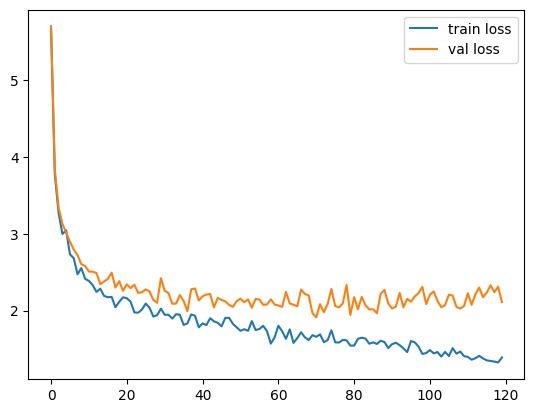

In [46]:
network_config.update({
    'batch_size': 32,
    'context_window': 32,
})

llama = Llama(network_config, tokenizer.vocab_size, 256, 8, 8).to(device)

optimizer = torch.optim.Adam(llama.parameters(), lr=5e-5)
train_loss, val_loss = train(llama, optimizer, network_config, epoch=12000, verbose=True)
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()

In [49]:
print(generate(llama, network_config, tokenizer))

                 where practice I read placed mini‑Calling liking a cravin each entire can be place—the fouring the challength rollege.
In high 


In [50]:
xs, ys = get_batch(dataset, **network_config, split="test")
logits, loss = llama(xs, ys)
print(loss)

tensor(2.3105, device='cuda:0', grad_fn=<NllLossBackward0>)
